# Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DATASET EXTRACTION
# 1. Ensure you have 'Data.zip' uploaded to your Google Drive.
# 2. Update the path below to point to your zip file location.
# 3. If running locally, skip this cell and manually extract your files into a 'Data' folder.

# Update this path to the location of your uploaded Data.zip
# DRIVE_ZIP_PATH = '/content/drive/MyDrive/CDC_Project/Data.zip'
# Update this to your desired destination folder
# DESTINATION_FOLDER = '/content/drive/MyDrive/CDC_Project/'

# !unzip -q "{DRIVE_ZIP_PATH}" -d "{DESTINATION_FOLDER}"

# print("Extraction complete. Data is ready for processing.")

!unzip /content/drive/MyDrive/CDC_Project/Data.zip -d /content/drive/MyDrive/CDC_Project/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137800085.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137800310.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137900320.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137900410.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137900490.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137910360.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137950350.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137950460.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137950720.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137960110.png  
  inflating: /content/drive/MyDrive/CDC_Project/Data/Images/Train/7137970210.png  
  inflating: /content/drive/MyDrive/

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 4.4 MB/s eta 0:00:00


In [3]:
!pip install shap

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import optuna
import shap
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
optuna.logging.set_verbosity(optuna.logging.INFO)

In [5]:
BASE_PATH = "/content/drive/MyDrive/CDC_Project/Data"

TRAIN_CSV = f"{BASE_PATH}/train.csv"
TEST_CSV  = f"{BASE_PATH}/test.csv"

TRAIN_IMAGE_DIR = f"{BASE_PATH}/Images/Train"
TEST_IMAGE_DIR  = f"{BASE_PATH}/Images/Test"

In [6]:
print(os.path.exists(TRAIN_CSV))
print(os.path.exists(TEST_CSV))

df = pd.read_csv(TRAIN_CSV)
print(df.shape)

print("Train images:", len(os.listdir(TRAIN_IMAGE_DIR)))
print("Test images:", len(os.listdir(TEST_IMAGE_DIR)))

True
True
(16209, 21)
Train images: 16110
Test images: 5396


In [7]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

## EDA on Tabular Data

In [ ]:
train_df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

## Price Distribution

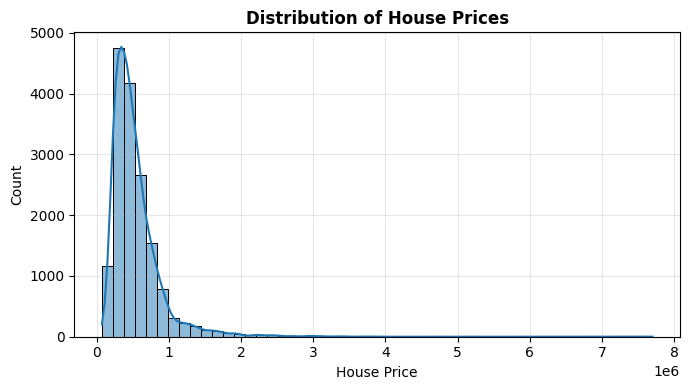

In [ ]:
plt.figure(figsize=(7, 4))
sns.histplot(
    train_df["price"],
    bins=50,
    kde=True
)
plt.title("Distribution of House Prices", fontsize=12, fontweight="bold")
plt.xlabel("House Price", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

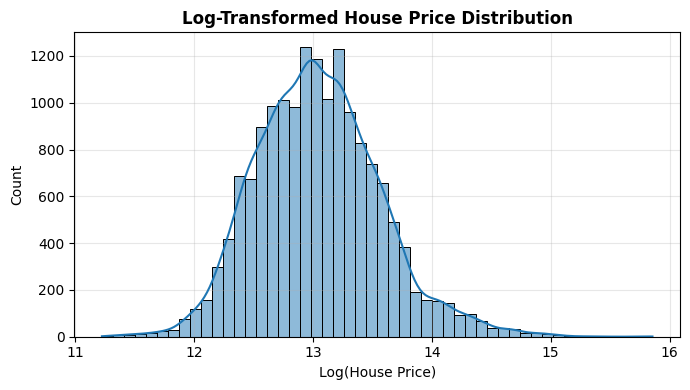

In [ ]:
plt.figure(figsize=(7, 4))
sns.histplot(
    np.log1p(train_df["price"]),
    bins=50,
    kde=True
)

plt.title("Log-Transformed House Price Distribution", fontsize=12, fontweight="bold")
plt.xlabel("Log(House Price)", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Relationship with Key Features

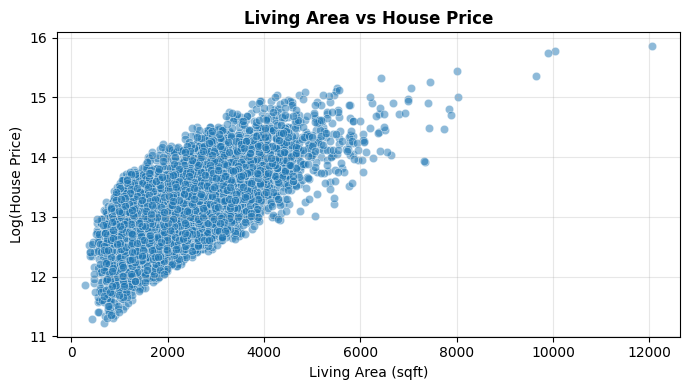

In [ ]:
plt.figure(figsize=(7, 4))
sns.scatterplot(
    x="sqft_living",
    y=np.log1p(train_df["price"]),
    data=df,
    alpha=0.5
)

plt.title("Living Area vs House Price", fontsize=12, fontweight="bold")
plt.xlabel("Living Area (sqft)")
plt.ylabel("Log(House Price)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

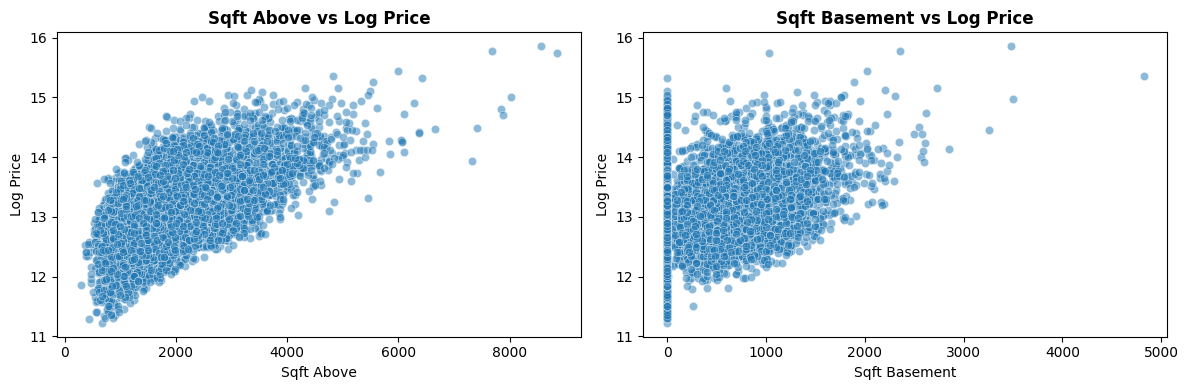

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.scatterplot(
    x=train_df["sqft_above"],
    y=np.log1p(train_df["price"]),
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title("Sqft Above vs Log Price", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Sqft Above")
axes[0].set_ylabel("Log Price")

sns.scatterplot(
    x=train_df["sqft_basement"],
    y=np.log1p(train_df["price"]),
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title("Sqft Basement vs Log Price", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Sqft Basement")
axes[1].set_ylabel("Log Price")

plt.tight_layout()
plt.show()

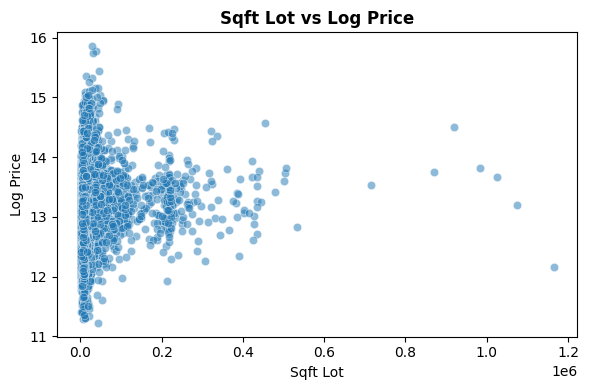

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=train_df["sqft_lot"],
    y=np.log1p(train_df["price"]),
    alpha=0.5
)
plt.title("Sqft Lot vs Log Price", fontsize=12, fontweight="bold")
plt.xlabel("Sqft Lot")
plt.ylabel("Log Price")
plt.tight_layout()
plt.show()

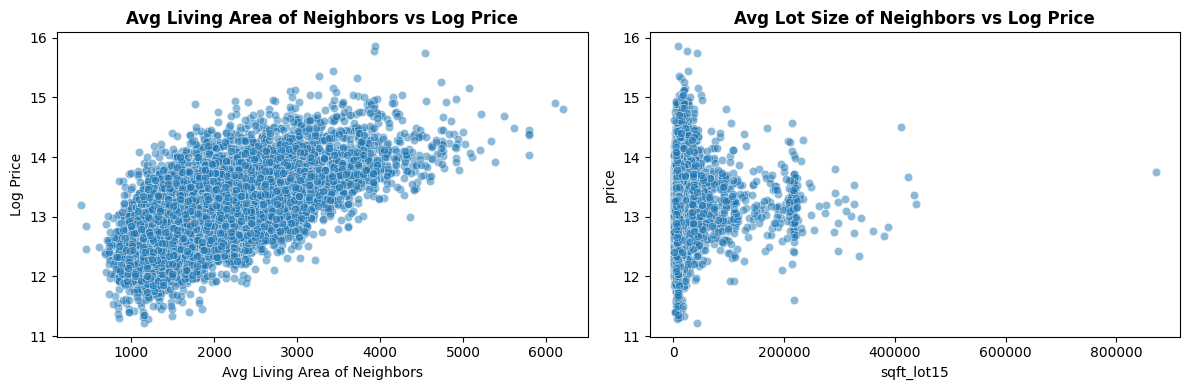

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.scatterplot(
    x=train_df["sqft_living15"],
    y=np.log1p(train_df["price"]),
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title("Avg Living Area of Neighbors vs Log Price", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Avg Living Area of Neighbors")
axes[0].set_ylabel("Log Price")

sns.scatterplot(
    x=train_df["sqft_lot15"],
    y=np.log1p(train_df["price"]),
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title("Avg Lot Size of Neighbors vs Log Price", fontsize=12, fontweight="bold")
axes

plt.tight_layout()
plt.show()

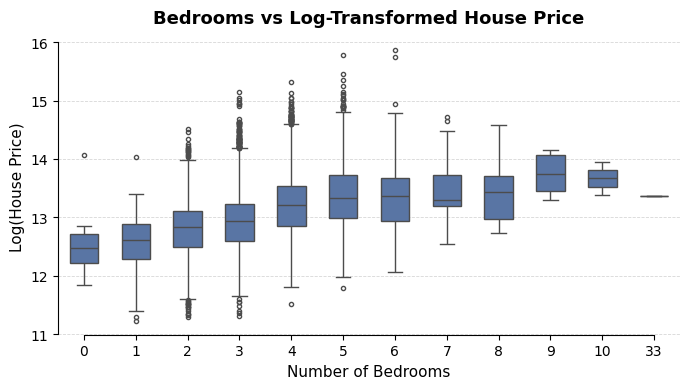

In [ ]:
plt.figure(figsize=(7, 4))

sns.boxplot(
    x="bedrooms",
    y=np.log1p(train_df["price"]),
    data=train_df,
    color="#4C72B0",
    width=0.55,
    fliersize=3,
    linewidth=1
)

plt.title(
    "Bedrooms vs Log-Transformed House Price",
    fontsize=13,
    fontweight="semibold",
    pad=10
)

plt.xlabel("Number of Bedrooms", fontsize=11)
plt.ylabel("Log(House Price)", fontsize=11)

plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.5)

sns.despine(trim=True)

plt.tight_layout()
plt.show()

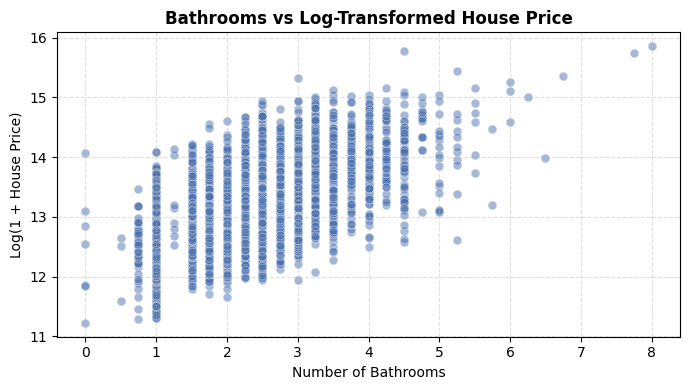

In [ ]:
plt.figure(figsize=(7, 4))

sns.scatterplot(
    x="bathrooms",
    y=np.log1p(train_df["price"]),
    data=df,
    color="#4C72B0",
    alpha=0.5,
    s=40
)

plt.title("Bathrooms vs Log-Transformed House Price", fontsize=12, fontweight="bold")
plt.xlabel("Number of Bathrooms", fontsize=10)
plt.ylabel("Log(1 + House Price)", fontsize=10)

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

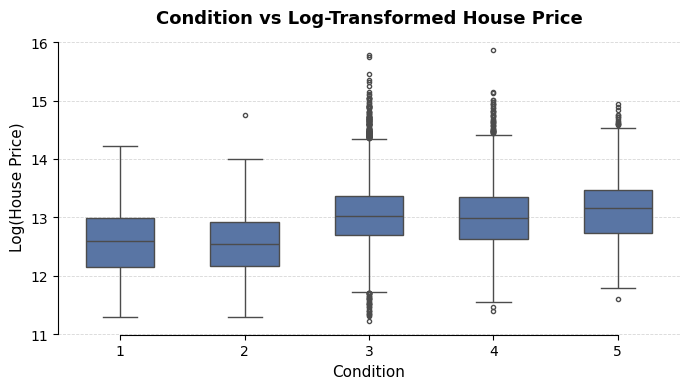

In [ ]:
plt.figure(figsize=(7, 4))

sns.boxplot(
    x="condition",
    y=np.log1p(train_df["price"]),
    data=train_df,
    color="#4C72B0",
    width=0.55,
    fliersize=3,
    linewidth=1
)

plt.title(
    "Condition vs Log-Transformed House Price",
    fontsize=13,
    fontweight="semibold",
    pad=10
)

plt.xlabel("Condition", fontsize=11)
plt.ylabel("Log(House Price)", fontsize=11)

plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
sns.despine(trim=True)

plt.tight_layout()
plt.show()

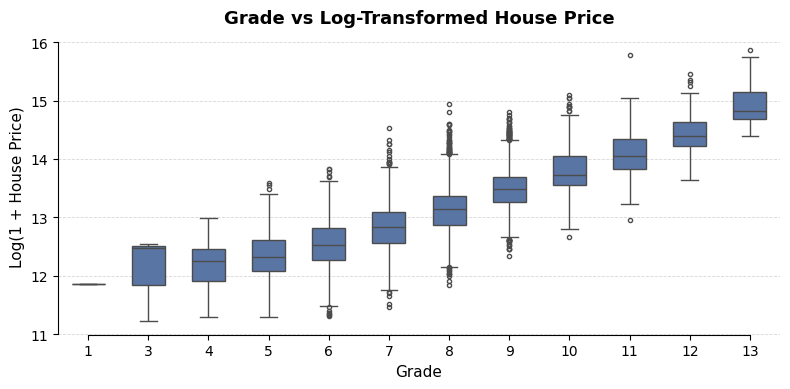

In [ ]:
plt.figure(figsize=(8, 4))

sns.boxplot(
    x="grade",
    y=np.log1p(train_df["price"]),
    data=train_df,
    color="#4C72B0",
    width=0.55,
    fliersize=3,
    linewidth=1
)

plt.title(
    "Grade vs Log-Transformed House Price",
    fontsize=13,
    fontweight="semibold",
    pad=10
)

plt.xlabel("Grade", fontsize=11)
plt.ylabel("Log(1 + House Price)", fontsize=11)

plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
sns.despine(trim=True)

plt.tight_layout()
plt.show()

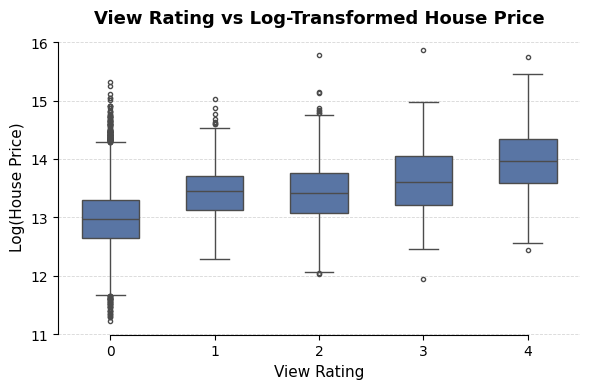

In [ ]:
plt.figure(figsize=(6, 4))

sns.boxplot(
    x="view",
    y=np.log1p(train_df["price"]),
    data=train_df,
    color="#4C72B0",
    width=0.55,
    fliersize=3,
    linewidth=1
)

plt.title(
    "View Rating vs Log-Transformed House Price",
    fontsize=13,
    fontweight="semibold",
    pad=10
)

plt.xlabel("View Rating", fontsize=11)
plt.ylabel("Log(House Price)", fontsize=11)

plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
sns.despine(trim=True)

plt.tight_layout()
plt.show()

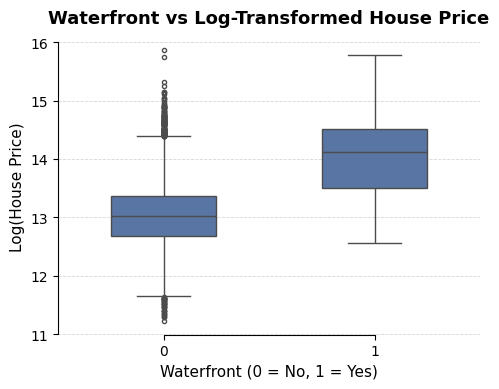

In [ ]:
plt.figure(figsize=(5, 4))

sns.boxplot(
    x="waterfront",
    y=np.log1p(train_df["price"]),
    data=train_df,
    color="#4C72B0",
    width=0.5,
    fliersize=3,
    linewidth=1
)

plt.title(
    "Waterfront vs Log-Transformed House Price",
    fontsize=13,
    fontweight="semibold",
    pad=10
)

plt.xlabel("Waterfront (0 = No, 1 = Yes)", fontsize=11)
plt.ylabel("Log(House Price)", fontsize=11)

plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
sns.despine(trim=True)

plt.tight_layout()
plt.show()

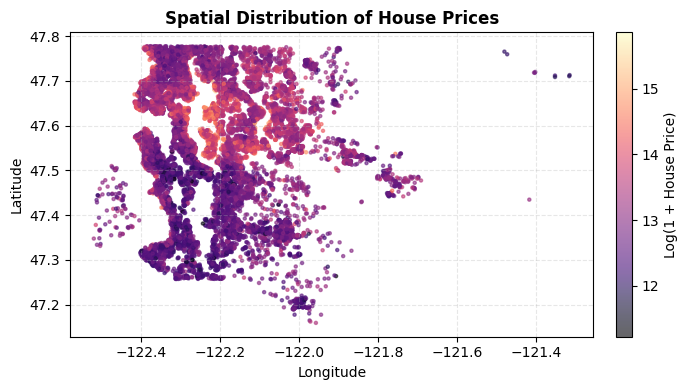

In [ ]:
plt.figure(figsize=(7, 4))

scatter = plt.scatter(
    train_df["long"],
    train_df["lat"],
    c=np.log1p(train_df["price"]),
    cmap="magma",
    s=5,
    alpha=0.6
)

cbar = plt.colorbar(scatter, fraction=0.046, pad=0.04)
cbar.set_label("Log(1 + House Price)", fontsize=10)

plt.title("Spatial Distribution of House Prices", fontsize=12, fontweight="bold")
plt.xlabel("Longitude", fontsize=10)
plt.ylabel("Latitude", fontsize=10)
plt.grid(linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

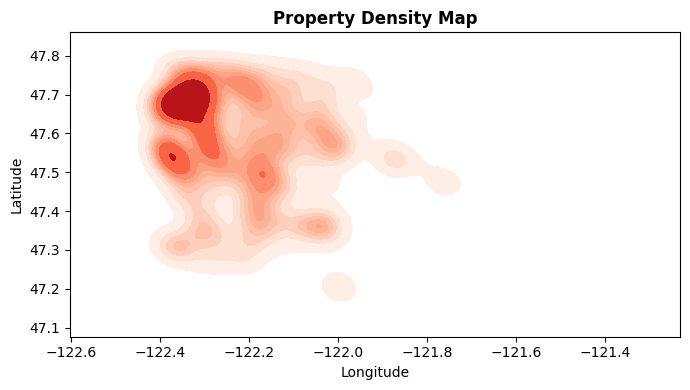

In [ ]:
plt.figure(figsize=(7, 4))
sns.kdeplot(
    x=train_df["long"],
    y=train_df["lat"],
    fill=True,
    cmap="Reds",
    thresh=0.05
)
plt.title("Property Density Map", fontsize=12, fontweight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

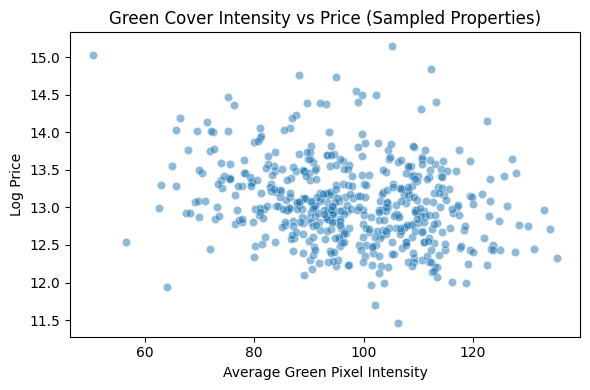

In [ ]:
SAMPLE_SIZE = 500

sample_df = train_df.sample(SAMPLE_SIZE, random_state=42)

def green_intensity(img_path):
    img = np.array(Image.open(img_path))
    return img[:, :, 1].mean()

sample_df["green_score"] = sample_df["id"].apply(
    lambda x: green_intensity(
        os.path.join(TRAIN_IMAGE_DIR, f"{int(x)}.png")
    )
)

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=sample_df["green_score"],
    y=np.log1p(sample_df["price"]),
    alpha=0.5
)
plt.title("Green Cover Intensity vs Price (Sampled Properties)")
plt.xlabel("Average Green Pixel Intensity")
plt.ylabel("Log Price")
plt.tight_layout()
plt.show()

In [ ]:
FEATURES = [
    "sqft_living", "sqft_above", "sqft_basement",
    "sqft_lot",
    "sqft_living15", "sqft_lot15",
    "condition", "grade",
    "view", "waterfront",
    "bedrooms", "bathrooms",
    "lat", "long"
]

corr_df = train_df[FEATURES].copy()
corr_df["log_price"] = np.log1p(train_df["price"])

corr_with_price = (
    corr_df
    .corr()["log_price"]
    .sort_values(ascending=False)
)

print(corr_with_price)

log_price        1.000000
grade            0.700249
sqft_living      0.693377
sqft_living15    0.615312
sqft_above       0.596904
bathrooms        0.550492
lat              0.452503
view             0.340868
bedrooms         0.337664
sqft_basement    0.315438
waterfront       0.161167
sqft_lot         0.098102
sqft_lot15       0.086677
long             0.052900
condition        0.033024
Name: log_price, dtype: float64


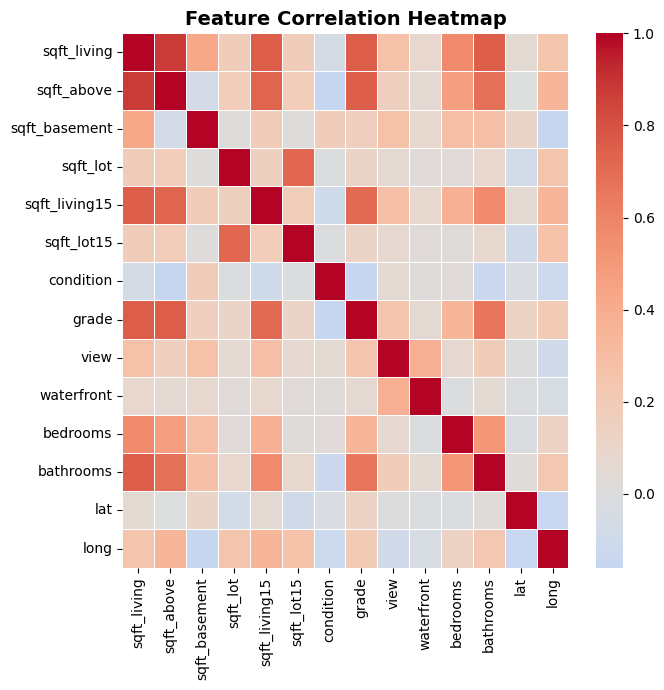

In [ ]:
plt.figure(figsize=(7, 7))
sns.heatmap(
    train_df[FEATURES].corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [17]:
FINAL_TABULAR_FEATURES = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "grade",
    "sqft_living15",
    "view",
    "waterfront",
    "lat",
    "long"
]

In [18]:
train_df = train_df[["id", "price"] + FINAL_TABULAR_FEATURES]

## Baseline Model

In [ ]:
X = train_df[FINAL_TABULAR_FEATURES]
y = np.log1p(train_df["price"])
ids = train_df["id"]

In [ ]:
X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(
    X, y, ids,
    test_size=0.2,
    random_state=42
)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2_lr = r2_score(y_val, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)

Linear Regression RMSE: 0.2691269729252436
Linear Regression R2: 0.7375308615867358


In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R2:", r2_rf)

Random Forest RMSE: 0.18373545946691833
Random Forest R2: 0.8776652744674004


In [ ]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)

rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R2:", r2_xgb)

XGBoost RMSE: 0.1754954900304929
XGBoost R2: 0.8883919004901613


In [ ]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_results = cross_validate(
    xgb,
    X,
    y,
    cv=cv,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "r2": "r2"
    },
    return_train_score=False
)

rmse_scores = -cv_results["test_rmse"]
r2_scores = cv_results["test_r2"]

print(f"CV RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
print(f"CV R²:   {r2_scores.mean():.4f}")

CV RMSE: 0.1751 ± 0.0012
CV R²:   0.8882


## Visualisation of Sample Images

In [19]:
sample_df = train_df.sample(12, random_state=42)
sample_df[["id", "price"]]

id    price
4226   1853200190   612000
11070   121059147   392000
2450    123039176   399888
1493   1862400518   385000
3894   3622059155   235000
1163   9512200420   390000
5821   4443800940   485000
7144   5457800930  1695000
14634  7202331420   650000
9157    886000015   275000
1373   6021501320   450000
14636  7853301400   625000

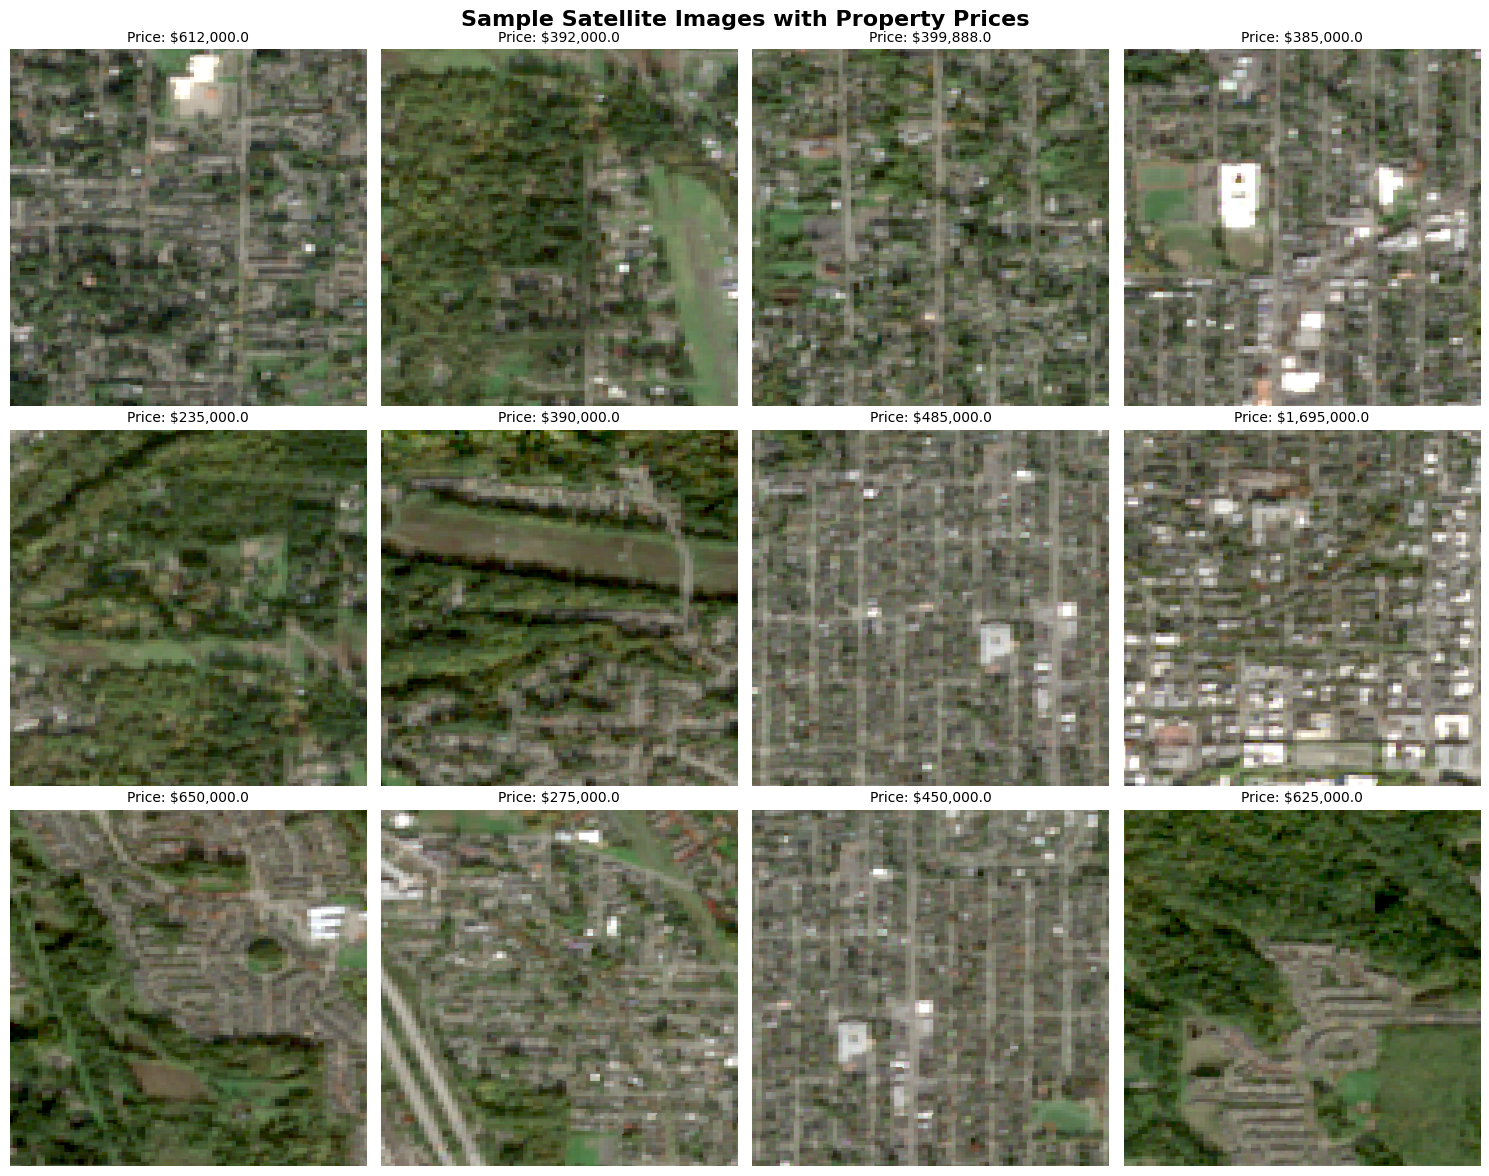

In [20]:
IMAGE_DIR = f"{BASE_PATH}/Images/Train"

plt.figure(figsize=(15, 12))

for i, (_, row) in enumerate(sample_df.iterrows()):
    img_id = str(int(row["id"]))
    img_path = os.path.join(IMAGE_DIR, f"{img_id}.png")

    img = Image.open(img_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Price: ${row['price']:,}", fontsize=10)

plt.suptitle("Sample Satellite Images with Property Prices", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

In [21]:
cheap = train_df.nsmallest(6, "price")
expensive = train_df.nlargest(6, "price")

compare_df = pd.concat([cheap, expensive]).reset_index(drop=True)
compare_df

id    price  bedrooms  bathrooms  sqft_living  grade  \
0   3421079032    75000         1       0.00          670      3   
1   8658300340    80000         1       0.75          430      4   
2   3028200080    81000         2       1.00          730      5   
3   3883800011    82000         3       1.00          860      6   
4   1523049188    84000         2       1.00          700      6   
5   1322049150    85000         2       1.00          910      5   
6   6762700020  7700000         6       8.00        12050     13   
7   9808700762  7062500         5       4.50        10040     11   
8   9208900037  6885000         6       7.75         9890     13   
9   1247600105  5110800         5       5.25         8010     12   
10  1924059029  4668000         5       6.75         9640     12   
11  3835500195  4489000         4       3.00         6430     12   

    sqft_living15  view  waterfront      lat     long  
0            1160     0           0  47.2638 -121.906  
1            1200     0           0  47.6499 -121.909  
2             860     0           0  47.4808 -122.315  
3            1140     0           0  47.4987 -122.341  
4            1490     0           0  47.4752 -122.271  
5            1160     0           0  47.3897 -122.236  
6            3940     3           0  47.6298 -122.323  
7            3930     2           1  47.6500 -122.214  
8            4540     4           0  47.6305 -122.240  
9            3430     4           1  47.6767 -122.211  
10           3270     4           1  47.5570 -122.210  
11           3720     0           0  47.6208 -122.219

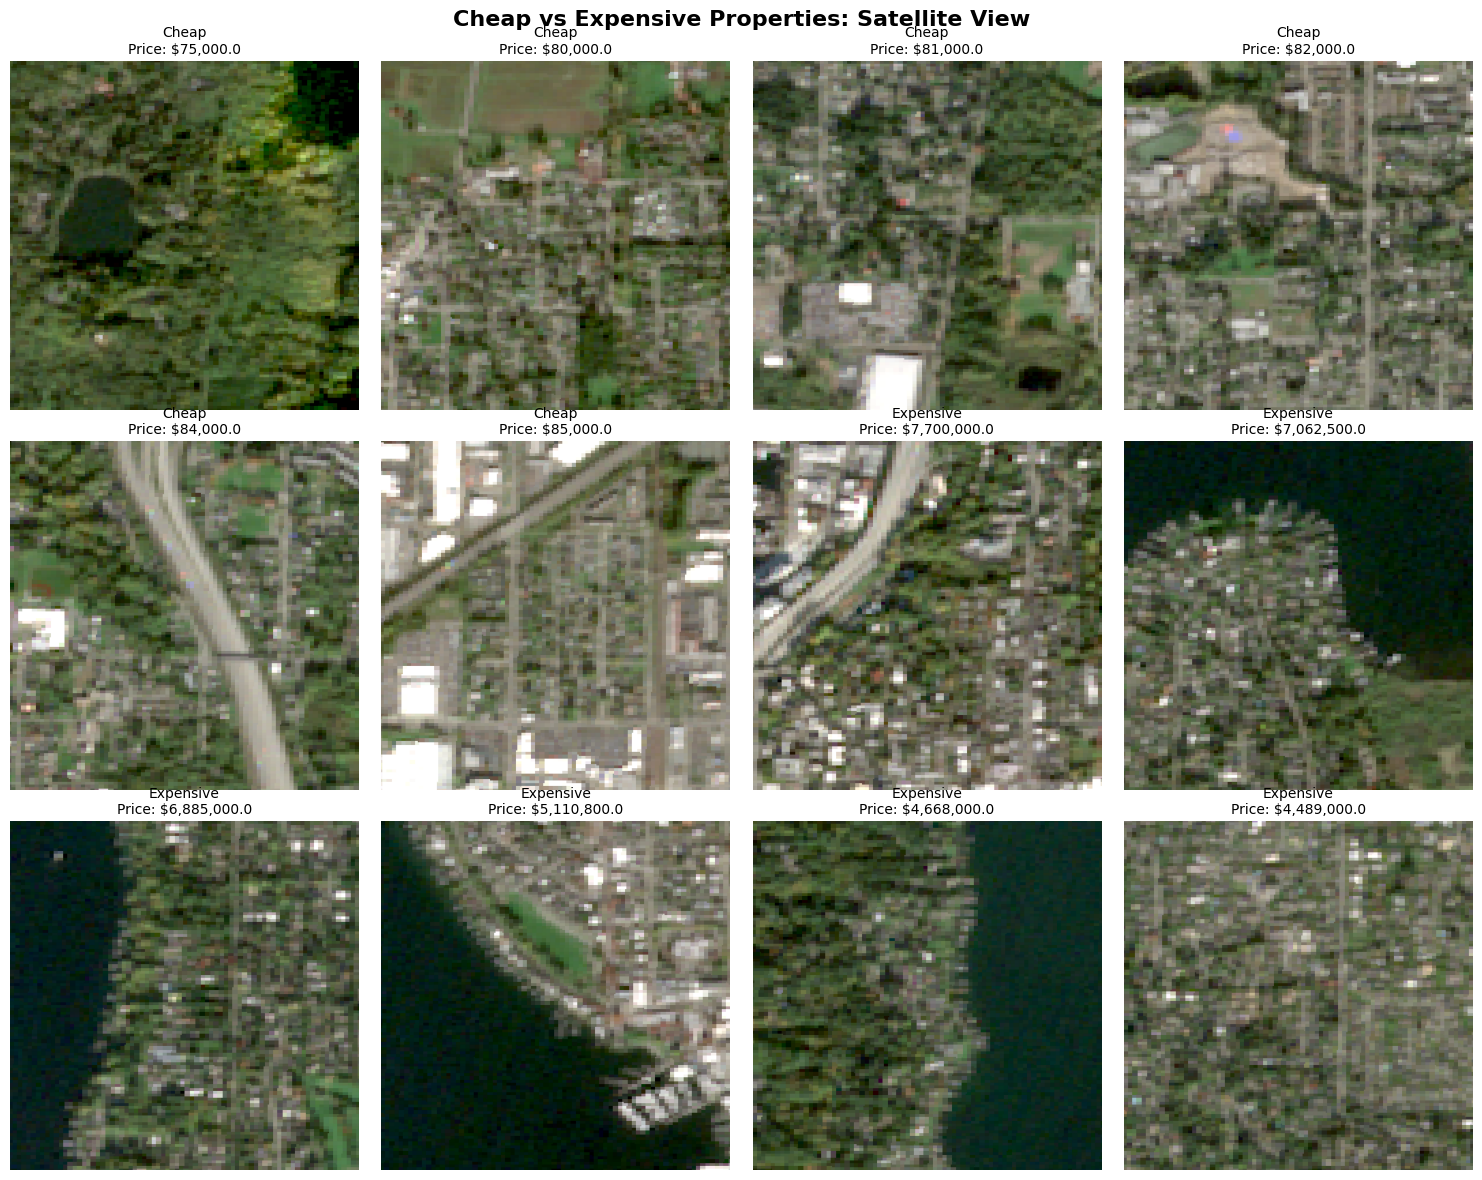

In [24]:
plt.figure(figsize=(15, 12))

for i, (_, row) in enumerate(compare_df.iterrows()):
    img_id = str(int(row["id"]))
    img_path = os.path.join(IMAGE_DIR, f"{img_id}.png")

    img = Image.open(img_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")

    label = "Cheap" if i < 6 else "Expensive"
    plt.title(f"{label}\nPrice: ${row['price']:,}", fontsize=10)

plt.suptitle(
    "Cheap vs Expensive Properties: Satellite View",
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

## Embeddings Generation Using ResNet50

In [ ]:
EMB_DIR = f"{BASE_PATH}/Embeddings"
os.makedirs(EMB_DIR, exist_ok=True)

In [ ]:
resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224, 224, 3)
)

resnet.trainable = False

print("ResNet50 loaded")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 loaded


In [ ]:
def extract_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))

    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    emb = resnet.predict(img_array, verbose=0)
    return emb.squeeze()

In [ ]:
def generate_embeddings(csv_path, image_dir, split_name):
    df = pd.read_csv(csv_path)

    emb_rows = []
    missing = 0

    print(f"\nExtracting {split_name} embeddings (row-aligned)...")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_id = int(row["id"])
        img_path = os.path.join(image_dir, f"{img_id}.png")

        if not os.path.exists(img_path):
            missing += 1
            emb = np.zeros(2048)  # safe fallback
        else:
            emb = extract_embedding(img_path)

        emb_rows.append(emb)

    emb_df = pd.DataFrame(
        emb_rows,
        columns=[f"img_emb_{i}" for i in range(2048)]
    )

    print(f"Done | Missing images: {missing}")
    return emb_df

In [ ]:
train_emb_df = generate_embeddings(
    TRAIN_CSV, TRAIN_IMAGE_DIR, "TRAIN"
)

test_emb_df = generate_embeddings(
    TEST_CSV, TEST_IMAGE_DIR, "TEST"
)


Extracting TRAIN embeddings (row-aligned)...


100%|██████████| 16209/16209 [32:49<00:00,  8.23it/s]


Done | Missing images: 0

Extracting TEST embeddings (row-aligned)...


100%|██████████| 5404/5404 [27:47<00:00,  3.24it/s]


Done | Missing images: 0


In [ ]:
train_emb_df.to_csv(f"{EMB_DIR}/train_image_embeddings.csv", index=False)
test_emb_df.to_csv(f"{EMB_DIR}/test_image_embeddings.csv", index=False)

print("Embeddings saved successfully!")

Embeddings saved successfully!


In [ ]:
train_emb_df = pd.read_csv(f"{EMB_DIR}/train_image_embeddings.csv")

test_emb_df = pd.read_csv(f"{EMB_DIR}/test_image_embeddings.csv")

In [ ]:
FINAL_TABULAR_FEATURES = [
    "id",
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "grade",
    "sqft_living15",
    "view",
    "waterfront",
    "lat",
    "long"
]

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_tab = train_df[FINAL_TABULAR_FEATURES + ["price"]]
test_tab  = test_df[FINAL_TABULAR_FEATURES]

train_final = pd.concat(
    [train_tab.reset_index(drop=True),
     train_emb_df.reset_index(drop=True)],
    axis=1
)

test_final = pd.concat(
    [test_tab.reset_index(drop=True),
     test_emb_df.reset_index(drop=True)],
    axis=1
)

In [ ]:
train_final.shape

(16209, 2059)

In [ ]:
test_final.shape

(5404, 2058)

In [ ]:
train_final.to_csv(f"{BASE_PATH}/train_hybrid.csv", index=False)
test_final.to_csv(f"{BASE_PATH}/test_hybrid.csv", index=False)

print("Multimodal datasets saved successfully!")

Multimodal datasets saved successfully!


## Hybrid Model Training on Subset of Training Data and Testing on Validation Data

In [ ]:
df_hybrid = pd.read_csv("/content/drive/MyDrive/CDC_Project/Data/train_hybrid.csv")

In [ ]:
TABULAR_FEATURES = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "grade",
    "sqft_living15",
    "view",
    "waterfront",
    "lat",
    "long"
]

IMAGE_FEATURES = [c for c in df_hybrid.columns if c.startswith("img_")]

HYBRID_FEATURES = TABULAR_FEATURES + IMAGE_FEATURES

In [ ]:
df_hybrid["log_price"] = np.log1p(df_hybrid["price"])

In [ ]:
train_df = df_hybrid[df_hybrid["id"].isin(id_train)]
val_df   = df_hybrid[df_hybrid["id"].isin(id_val)]

X_train = train_df[HYBRID_FEATURES]
y_train = train_df["log_price"]

X_val = val_df[HYBRID_FEATURES]
y_val = val_df["log_price"]

In [ ]:
xgb_hybrid = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_hybrid.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
val_preds = xgb_hybrid.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2   = r2_score(y_val, val_preds)

print(f"Hybrid RMSE: {rmse:.4f}")
print(f"Hybrid R²: {r2:.4f}")

Hybrid RMSE: 0.1794
Hybrid R²: 0.8833


In [ ]:
X = df_hybrid[HYBRID_FEATURES]
y = np.log1p(df_hybrid["price"])

xgb_hybrid = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_results = cross_validate(
    xgb_hybrid,
    X,
    y,
    cv=cv,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "r2": "r2"
    },
    return_train_score=False
)

rmse_scores = -cv_results["test_rmse"]
r2_scores   = cv_results["test_r2"]

print(f"Hybrid CV RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
print(f"Hybrid CV R²:   {r2_scores.mean():.4f}")

Hybrid CV RMSE: 0.1816 ± 0.0014
Hybrid CV R²:   0.8796


## Final Model

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [ ]:
FINAL_TABULAR_FEATURES = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "grade",
    "sqft_living15",
    "view",
    "waterfront",
    "lat",
    "long"
]

In [ ]:
train_df = train_df[["id", "price"] + FINAL_TABULAR_FEATURES]

In [ ]:
X = train_df[FINAL_TABULAR_FEATURES]
y = np.log1p(train_df["price"])

In [ ]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "objective": "reg:squarederror",
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error"
    )

    return -scores.mean()

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-12-24 07:01:24,140] A new study created in memory with name: no-name-f0d936cf-3c03-4eeb-859d-f40f99639da5
[I 2025-12-24 07:01:32,816] Trial 0 finished with value: 0.1751065858261162 and parameters: {'n_estimators': 211, 'max_depth': 8, 'learning_rate': 0.07704931924798207, 'subsample': 0.9479878260952288, 'colsample_bytree': 0.6804685175216474, 'min_child_weight': 8}. Best is trial 0 with value: 0.1751065858261162.
[I 2025-12-24 07:01:34,886] Trial 1 finished with value: 0.1771558131832062 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.045329206109477056, 'subsample': 0.7909478233057028, 'colsample_bytree': 0.8131086688483807, 'min_child_weight': 10}. Best is trial 0 with value: 0.1751065858261162.
[I 2025-12-24 07:01:36,540] Trial 2 finished with value: 0.18650928485221466 and parameters: {'n_estimators': 402, 'max_depth': 3, 'learning_rate': 0.043894031479438336, 'subsample': 0.7163181227516612, 'colsample_bytree': 0.7682866940342747, 'min_child_weig

In [ ]:
best_params = study.best_params
print("Best RMSE:", study.best_value)
print("Best Params:", best_params)

Best RMSE: 0.1739589070511728
Best Params: {'n_estimators': 594, 'max_depth': 6, 'learning_rate': 0.03869289735362899, 'subsample': 0.8705286875648764, 'colsample_bytree': 0.8560919950156594, 'min_child_weight': 3}


In [ ]:
final_xgb = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8560919950156594, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03869289735362899,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=594, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
X_test = test_df[FINAL_TABULAR_FEATURES]
test_ids = test_df["id"]

test_log_preds = final_xgb.predict(X_test)
test_preds = np.expm1(test_log_preds)

In [ ]:
submission = pd.DataFrame({
    "id": test_ids,
    "predicted_price": test_preds
})

submission.to_csv("submission.csv", index=False)

## SHAP on Final Tabular Model

In [ ]:
explainer = shap.TreeExplainer(final_xgb)

In [ ]:
shap_values = explainer.shap_values(X)

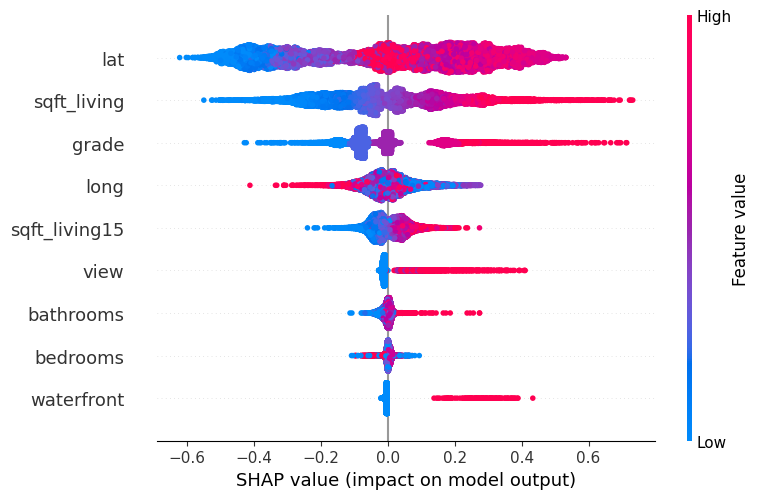

In [ ]:
shap.summary_plot(
    shap_values,
    X,
    feature_names=FINAL_TABULAR_FEATURES,
    show=True
)

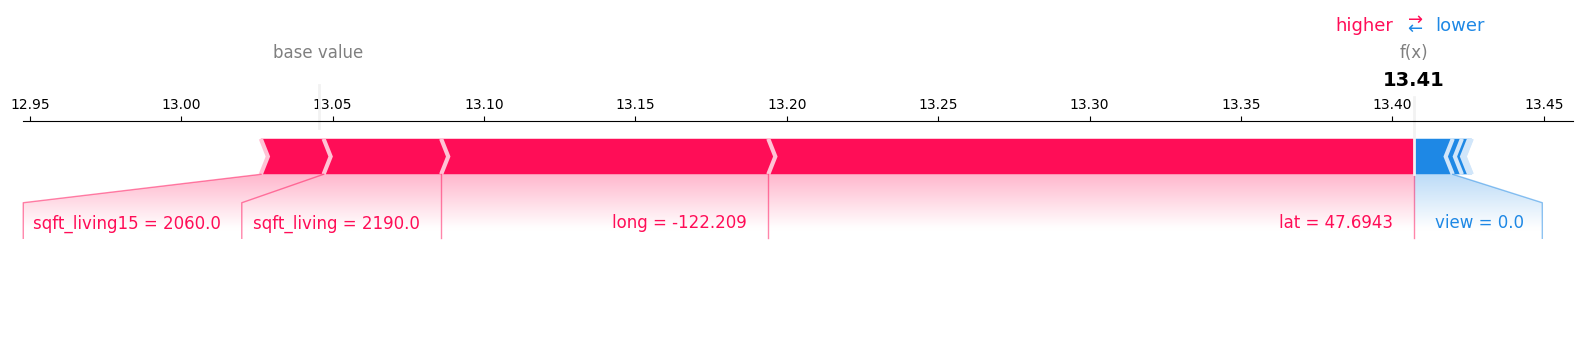

In [ ]:
idx = 67

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X.iloc[idx],
    matplotlib=True
)

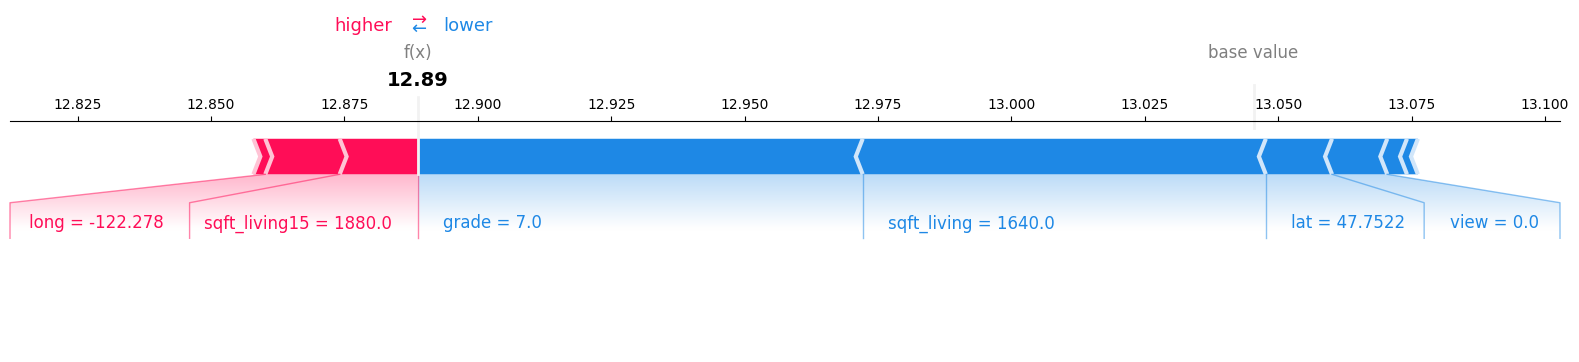

In [ ]:
idx = 1000

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X.iloc[idx],
    matplotlib=True
)